In [75]:
import random
import pandas as pd
import cv2
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import keras
from keras import backend as K 
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

%matplotlib inline

# Hide Warnings
pd.options.mode.chained_assignment = None

# Set Seeds
tf.random.set_seed(42)
seed = 42
np.random.seed(42) # numpy seed (also used by keras)
random.seed(42)

# Intelligent Data Analysis 2 Project: EuroSAT

## Structure

- Problem Setting
	- Definition
	- Appropiate Learning Problem
	- Define Target/Input Attributes
- Analysis / EDA
- Method
	- Suitable Approach (at least two)
	- Baseline Method
- Experiments
	- Hyperparameter Tuning
	- Evaluation (Comparison of Models)
- Conclusions
	- Result Interpretation

## Problem Setting

EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification (Vol. 12, Number 7, pp. 2217–2226). Zenodo. https://doi.org/10.5281/zenodo.7711810

EuroSAT is a land use and land cover classification dataset. The dataset is based on Sentinel-2 satellite imagery covering 13 spectral bands and consists of 10 LULC classes with a total of 27,000 labeled and geo-referenced images. 

The RGB version of the dataset includes the optical R, G and B frequency bands encoded as JPEG images. The multi-spectral version of the EuroSAT dataset includes all 13 Sentinel-2 bands in the original value range. This project uses the RGB version.

## Explorative Data Analysis

In [76]:
ds, info = tfds.load('eurosat', split='all', data_dir='./data/eurosat', with_info=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

ds_numpy = tfds.as_numpy(ds)

images = []
labels = []

for image in ds_numpy:
    images.append(image['image'])
    labels.append(image['label'])
    
print(len(images))
print(len(labels))

images = np.array(images)
labels = np.array(labels)

<PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
27000
27000


In [77]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [78]:
# Labels
print("Number of Labels:", info.features["label"].num_classes)
print("Label Names:", info.features["label"].names)
# print(info.features["label"].int2str(7))  # Human readable version (8 -> 'cat')
# print(info.features["label"].str2int('AnnualCrop'))

Number of Labels: 10
Label Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


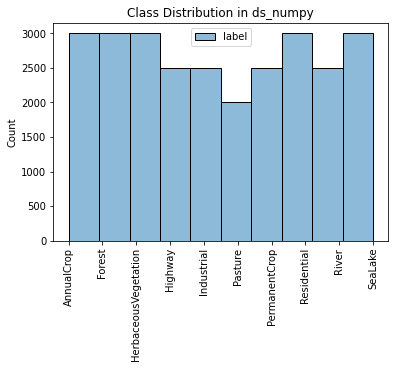

In [79]:
class_distribution = sns.histplot(ds_numpy, bins=10).set_title("Class Distribution in ds_numpy")
plt.xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)
plt.show()
# class_distribution.figure.savefig('report/figures/class_distribution.png', dpi=300, transparent=False, facecolor='white')

# Pasture - 2000
# Highway, Industrial, PermanentCrop, River - 2500
# AnnualCrop, Forest, HerbaceousVegetation, Residential, SeaLake - 3000

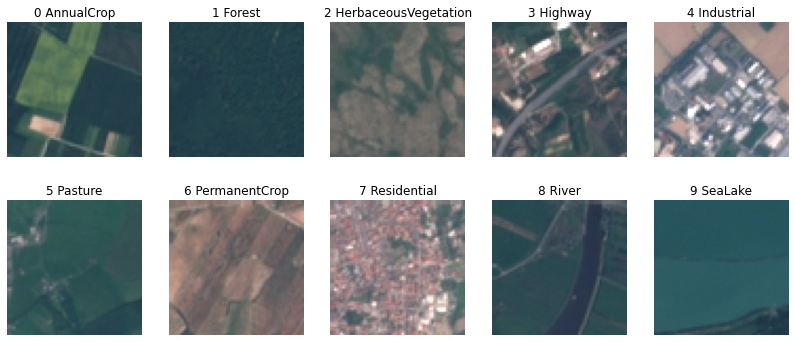

In [80]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

label_id = 0
for x in range(0, 2):
        for y in range(0, 5):            
            for image, label in zip(images, labels):
                if (label == label_id):
                        axs[x, y].imshow(image)
                        axs[x, y].set_title(str(label) + " " + info.features["label"].int2str(label))
                        axs[x, y].axis('off')
                        label_id += 1
                        break

## Preprocessing

In [81]:
# train_test_split shuffles the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=seed)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.50, random_state=seed)

print(len(X_train))
print(len(X_test))
print(len(X_validation))

21600
2700
2700


In [82]:
# Data Augmentation of the training data set
X_train_augmented = []
y_train_augmented = []

for image, label in zip(X_train, y_train):
    # flip (cautious)
    # not implemented
    
    # rotate
    # img_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_180 = cv2.rotate(image, cv2.ROTATE_180)
    # img_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # X_train_augmented.append(img_90)
    X_train_augmented.append(img_180)
    # X_train_augmented.append(img_270)
    
    # y_train_augmented.append(label)
    y_train_augmented.append(label)
    # y_train_augmented.append(label)

X_train_complete = np.array(list(X_train) + X_train_augmented)
print(len(X_train_complete))

y_train_complete = np.array(list(y_train) + y_train_augmented)
print(len(y_train_complete))

43200
43200


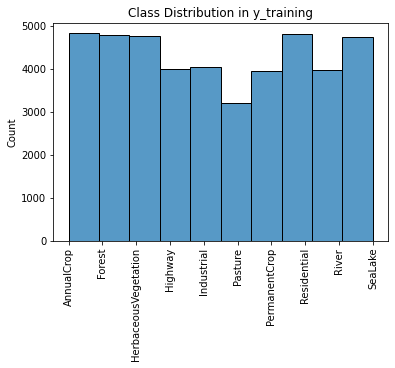

In [83]:
class_distribution = sns.histplot(y_train_complete, bins=10).set_title("Class Distribution in y_training")
plt.xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)
plt.show()

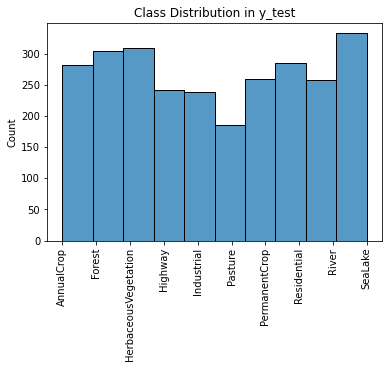

In [84]:
class_distribution = sns.histplot(y_test, bins=10).set_title("Class Distribution in y_test")
plt.xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)
plt.show()

In [85]:
# normalize images

min_val = np.amin(X_train_complete)
max_val = np.amax(X_train_complete)
X_train_rescaled = (X_train_complete.astype(float) - min_val) / (max_val - min_val)
print("(x_train) min_val:", min_val, "max_val:", max_val)

min_val = np.amin(X_test)
max_val = np.amax(X_test)
X_test_rescaled = (X_test.astype(float) - min_val) / (max_val - min_val)
print("(x_test) min_val:", min_val, "max_val:", max_val)

(x_train) min_val: 0 max_val: 255
(x_test) min_val: 8 max_val: 255


In [86]:
X_train_complete[0]

array([[[ 82,  93, 115],
        [ 83,  94, 114],
        [ 98, 109, 129],
        ...,
        [116, 113, 120],
        [113, 110, 121],
        [109, 106, 117]],

       [[ 82,  93, 113],
        [ 82,  95, 114],
        [ 98, 111, 130],
        ...,
        [116, 115, 123],
        [115, 112, 123],
        [110, 107, 118]],

       [[ 79,  92, 109],
        [ 77,  93, 109],
        [ 84, 101, 119],
        ...,
        [114, 117, 126],
        [113, 111, 124],
        [112, 108, 122]],

       ...,

       [[ 47,  76,  90],
        [ 47,  76,  90],
        [ 46,  75,  89],
        ...,
        [ 43,  75,  86],
        [ 47,  77,  88],
        [ 47,  77,  88]],

       [[ 46,  75,  91],
        [ 45,  74,  90],
        [ 44,  73,  89],
        ...,
        [ 46,  76,  87],
        [ 47,  75,  86],
        [ 47,  75,  86]],

       [[ 39,  68,  84],
        [ 38,  67,  83],
        [ 38,  67,  83],
        ...,
        [ 47,  77,  88],
        [ 45,  73,  84],
        [ 43,  71,  82]]

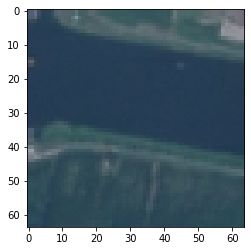

In [87]:
plt.imshow(X_train_rescaled[0])

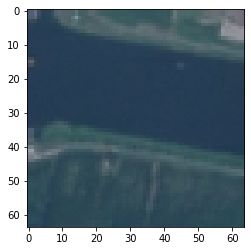

In [88]:
plt.imshow(X_train_complete[0])

In [89]:
nb_classes = 10
oneHotLabelTrain = np_utils.to_categorical(y_train_complete, nb_classes)
oneHotLabelTest  = np_utils.to_categorical(y_test,  nb_classes)
oneHotLabelValidation  = np_utils.to_categorical(y_validation,  nb_classes)

In [90]:
oneHotLabelTrain.shape

(43200, 10)

## Method Application

### CNN based on exercise (baseline)

In [91]:
# simple cnn
def getCNNModel():
    input_shape = (64, 64, 3)
    nb_filters_one = 32
    nb_filters_two = 64
    nb_conv = 3
    nb_pool = 2
    dense_size = 128
    cnnModel = Sequential()
    cnnModel.add(Conv2D(nb_filters_one, kernel_size=(nb_conv, nb_conv),
                     activation='relu',
                     input_shape=input_shape)) # convolutional layer
    cnnModel.add(MaxPooling2D(pool_size=(nb_pool, nb_pool))) # max pooling layer
    cnnModel.add(Dropout(0.25))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(dense_size, activation='relu')) # dense layer
    cnnModel.add(Dropout(0.5))
    cnnModel.add(Dense(nb_classes, activation='softmax'))

    cnnModel.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return cnnModel

cnnModel = getCNNModel()
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 128)               3936384   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [92]:
batch_size = 128
numEpochs = 10

cnnModel = getCNNModel()
learnHistCNN    = cnnModel.fit(X_train_rescaled,oneHotLabelTrain,
                               validation_data=(X_test_rescaled,oneHotLabelTest),
                               batch_size=batch_size,
                               epochs=numEpochs)

Epoch 1/10
338/338 [==============================] - 122s 343ms/step - loss: 1.9820 - accuracy: 0.2506 - val_loss: 1.7398 - val_accuracy: 0.3533
Epoch 2/10
338/338 [==============================] - 103s 306ms/step - loss: 1.7180 - accuracy: 0.3549 - val_loss: 1.5550 - val_accuracy: 0.4504
Epoch 3/10
338/338 [==============================] - 83s 244ms/step - loss: 1.5932 - accuracy: 0.4134 - val_loss: 1.5709 - val_accuracy: 0.3948
Epoch 4/10
338/338 [==============================] - 81s 240ms/step - loss: 1.4900 - accuracy: 0.4634 - val_loss: 1.3755 - val_accuracy: 0.5152
Epoch 5/10
338/338 [==============================] - 89s 263ms/step - loss: 1.3969 - accuracy: 0.5045 - val_loss: 1.1992 - val_accuracy: 0.6004
Epoch 6/10
338/338 [==============================] - 93s 276ms/step - loss: 1.3052 - accuracy: 0.5378 - val_loss: 1.1320 - val_accuracy: 0.6211
Epoch 7/10
338/338 [==============================] - 98s 289ms/step - loss: 1.2394 - accuracy: 0.5634 - val_loss: 1.1299 - val_

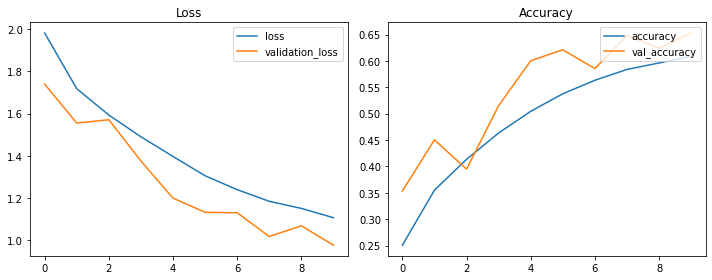

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(learnHistCNN.history['loss'], label="loss")
axes[0].plot(learnHistCNN.history['val_loss'], label="validation_loss")
axes[0].title.set_text('Loss')
axes[0].legend(loc="upper right")

axes[1].plot(learnHistCNN.history['accuracy'], label="accuracy")
axes[1].plot(learnHistCNN.history['val_accuracy'], label="val_accuracy")
axes[1].title.set_text('Accuracy')
axes[1].legend(loc="upper right")

fig.tight_layout()

85/85 [==============================] - 3s 26ms/step


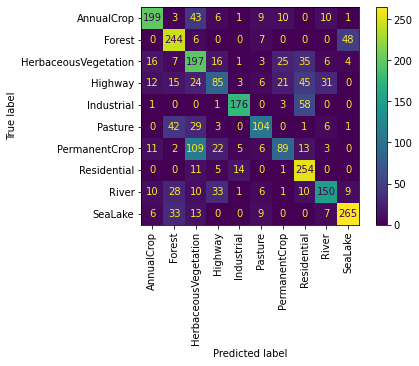

In [94]:
preds = cnnModel.predict(X_test_rescaled)
class_labels = np.argmax(preds, axis=1)

a = ConfusionMatrixDisplay.from_predictions(y_test, 
                                            class_labels, 
                                            display_labels=info.features["label"].names, 
                                            xticks_rotation='vertical')

### CNN (more advanced)

### ResNet (transfer learning)

In [95]:
# res = cv2.resize(X_test_rescaled[0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
# res.shape

base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (64,64,3))

for layer in base_model.layers:
    layer.trainable = False

In [96]:
x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)

In [97]:
head_model = Model(inputs = base_model.input, outputs = predictions)

head_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [98]:
history = head_model.fit(X_train_rescaled, oneHotLabelTrain, batch_size=128, epochs=10, 
                         validation_data=(X_test_rescaled, oneHotLabelTest))

Epoch 1/10
338/338 [==============================] - 523s 2s/step - loss: 2.1979 - accuracy: 0.1916 - val_loss: 2.1049 - val_accuracy: 0.2548
Epoch 2/10
338/338 [==============================] - 393s 1s/step - loss: 1.9992 - accuracy: 0.2591 - val_loss: 1.9159 - val_accuracy: 0.2741
Epoch 3/10
338/338 [==============================] - 435s 1s/step - loss: 1.9158 - accuracy: 0.2844 - val_loss: 1.9234 - val_accuracy: 0.3230
Epoch 4/10
338/338 [==============================] - 329s 971ms/step - loss: 1.8814 - accuracy: 0.2973 - val_loss: 2.0237 - val_accuracy: 0.2156
Epoch 5/10
338/338 [==============================] - 314s 930ms/step - loss: 1.8243 - accuracy: 0.3121 - val_loss: 1.8461 - val_accuracy: 0.2774
Epoch 6/10
338/338 [==============================] - 304s 900ms/step - loss: 1.8003 - accuracy: 0.3256 - val_loss: 1.7812 - val_accuracy: 0.3167
Epoch 7/10
338/338 [==============================] - 303s 896ms/step - loss: 1.7735 - accuracy: 0.3316 - val_loss: 1.7421 - val_accu

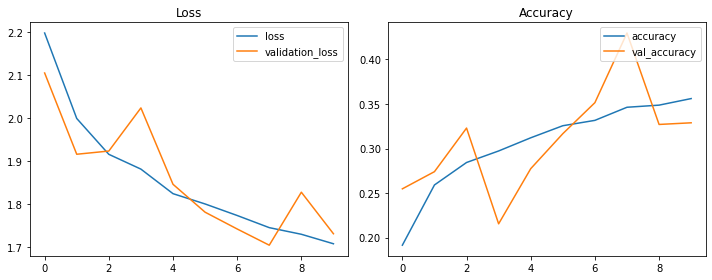

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(history.history['loss'], label="loss")
axes[0].plot(history.history['val_loss'], label="validation_loss")
axes[0].title.set_text('Loss')
axes[0].legend(loc="upper right")

axes[1].plot(history.history['accuracy'], label="accuracy")
axes[1].plot(history.history['val_accuracy'], label="val_accuracy")
axes[1].title.set_text('Accuracy')
axes[1].legend(loc="upper right")

fig.tight_layout()

85/85 [==============================] - 21s 226ms/step


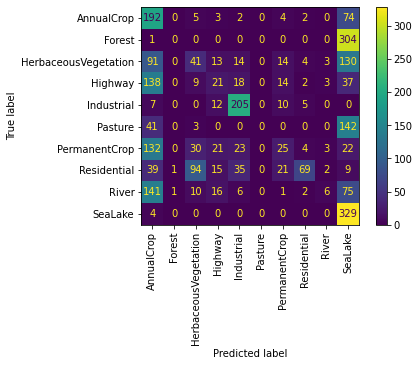

In [100]:
preds = head_model.predict(X_test_rescaled)
class_labels = np.argmax(preds, axis=1)

a = ConfusionMatrixDisplay.from_predictions(y_test, 
                                            class_labels, 
                                            display_labels=info.features["label"].names, 
                                            xticks_rotation='vertical')

## Experiments

In [102]:
# for hyperparameter tuning
# https://github.com/into-ai/deeplearning2020/blob/master/woche4/notebooks/hyperparameter-optimization/hyperparameter-optimization.ipynb

## Conclusions

In [103]:
# Comparing Loss and Accuracy of all models

# Future Tests: Vision Transformers (see Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929)
# Autoencoder also possible but not the best option
# - Vision Transformers https://keras.io/examples/vision/image_classification_with_vision_transformer/